In [1]:
from config import Cfg as cfg

In [2]:
import mysql.connector
import pandas as pd

cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df = pd.read_sql(query, con=cnx)

cnx.close()


## Total number of races

In [3]:
len(df)

220

## Races that have not been discontinued have geographic infos (lat/lon points) in the "map" field.

In [40]:
active = ((df.map != '') & (df.map.isna() == False))
active = df['info'].dropna().index
len(df.iloc[active])

160

## Example of bike route

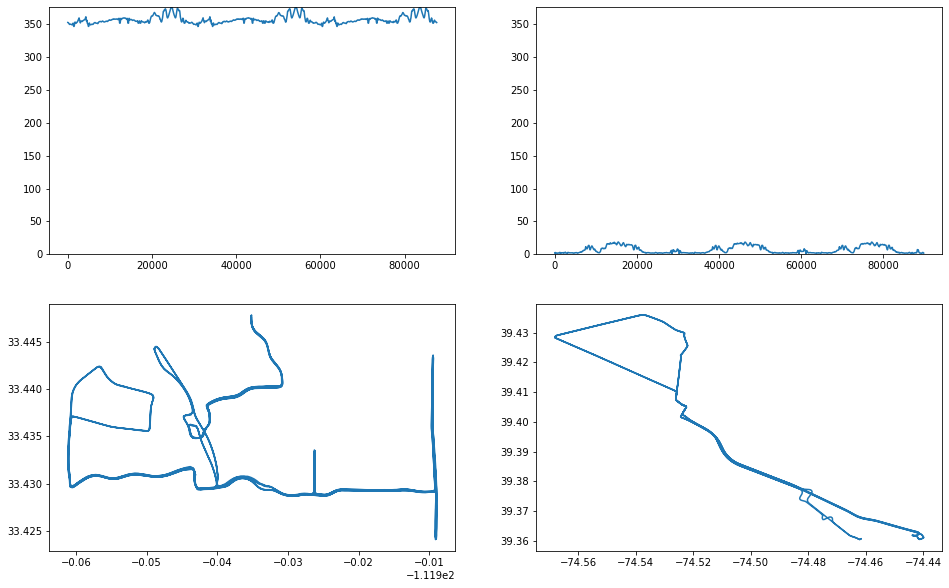

In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


races = ['Arizona70.3', 'atlanticcity70.3']
sport = 'bike'


fig,axes = plt.subplots(ncols=len(races), nrows=2, figsize=(len(races)*8, 10))
axes = axes.ravel()

# for scaling purpose
minElevation = 10000
maxElevation = 0

for i,race in enumerate(races):
    # all geo data
    race_map = json.loads(df.loc[df.race==race].map.values[0]) 
    # sport data
    race_sport = race_map[sport]
    # gps data
    race_sport_pts = np.array(race_sport['points'])
    
    minElevation = np.min(race_sport['elevation']) if np.min(race_sport['elevation'])<minElevation else minElevation
    maxElevation = np.max(race_sport['elevation']) if np.max(race_sport['elevation'])>maxElevation else maxElevation

    axes[i].plot(race_sport['distance'], race_sport['elevation'])
    axes[i+2].plot(race_sport_pts[:, 0], race_sport_pts[:, 1])

for ax in axes[:2]:
    ax.set_ylim(minElevation, maxElevation)
# ax1.set_ylim(0)
# ax2.set_ylim(ax1.get_ylim())

(0.0, 377.782)

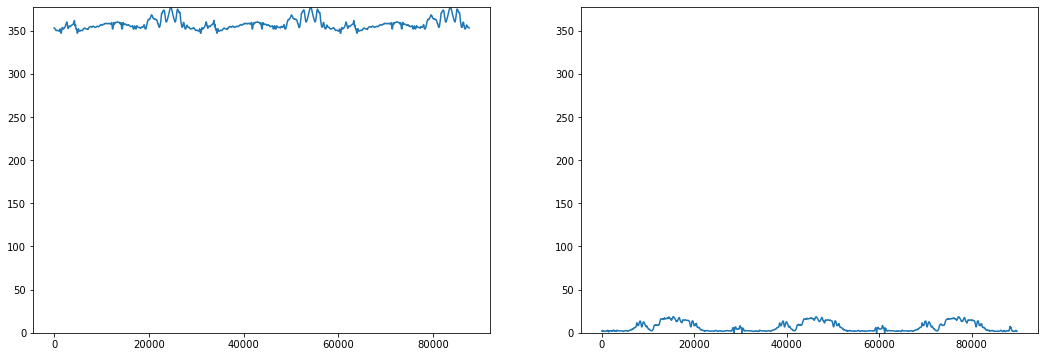

# sinuosity of a line

(https://gamedev.stackexchange.com/a/98111)


In [5]:
def get_angle_between(v1, v2, degrees=False):
    angle = np.math.atan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
    if degrees:
        angle = np.degrees(angle)
    return angle

def get_successive_angles(x, y):
    x_diff = x[1:] - x[:-1]
    y_diff = y[1:] - y[:-1]
    angles = []
    for i in range(len(x_diff)-1):
        v1 = [x_diff[i], y_diff[i]]
        v2 = [x_diff[i+1], y_diff[i+1]]
        angles.append(np.abs(get_angle_between(v1, v2, degrees=True)))
    return np.array(angles)

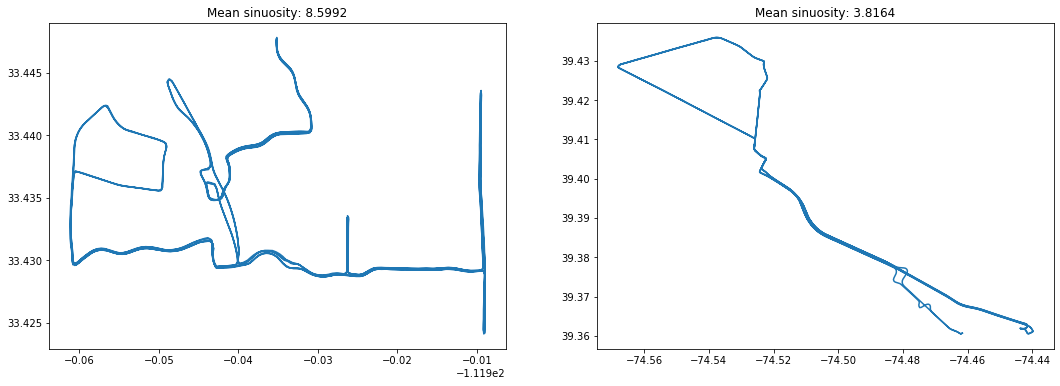

In [6]:
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# bike data
bike_arizona = arizona_map['bike']
bike_atlanticcity = atlanticcity_map['bike']

pts_arizona = np.array(bike_arizona['points'])
pts_atlanticcity = np.array(bike_atlanticcity['points'])

ax1.plot(pts_arizona[:, 0], pts_arizona[:, 1])
ax2.plot(pts_atlanticcity[:, 0], pts_atlanticcity[:, 1])

angles_arizona = get_successive_angles(pts_arizona[:, 0], pts_arizona[:, 1]).mean()
angles_atlanticcity = get_successive_angles(pts_atlanticcity[:, 0], pts_atlanticcity[:, 1]).mean()

ax1.set_title(f"Mean sinuosity: {angles_arizona.mean():.4f}")
ax2.set_title(f"Mean sinuosity: {angles_atlanticcity.mean():.4f}");


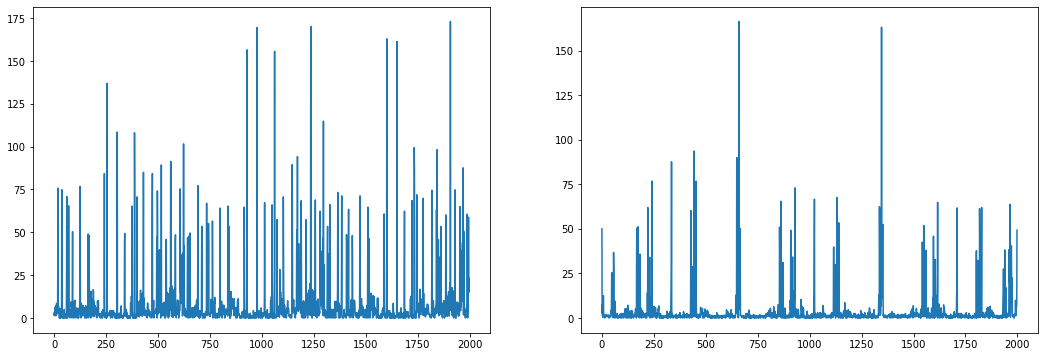

In [9]:
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

ax1.plot(get_successive_angles(pts_arizona[:, 0], pts_arizona[:, 1]))
ax2.plot(get_successive_angles(pts_atlanticcity[:, 0], pts_atlanticcity[:, 1]))




In [11]:
# other possibility
# (https://stackoverflow.com/a/13849249)
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


In [7]:
class BoundingBox(object):
    """
    A 2D bounding box
    """
    def __init__(self, points):
        """
        Compute the upright 2D bounding box for a set of
        2D coordinates in a (n,2) numpy array.
        You can access the bbox using the
        (minx, maxx, miny, maxy) members.
        """
        if len(points.shape) != 2 or points.shape[1] != 2:
            raise ValueError("Points must be a (n,2), array but it has shape {}".format(
                points.shape))
        if points.shape[0] < 1:
            raise ValueError("Can't compute bounding box for empty coordinates")
        self.minx, self.miny = np.min(points, axis=0)
        self.maxx, self.maxy = np.max(points, axis=0)

    @property
    def width(self):
        """X-axis extent of the bounding box"""
        return self.maxx - self.minx

    @property
    def height(self):
        """Y-axis extent of the bounding box"""
        return self.maxy - self.miny

    @property
    def area(self):
        """width * height"""
        return self.width * self.height

    @property
    def aspect_ratio(self):
        """width / height"""
        return self.width / self.height

    @property
    def center(self):
        """(x,y) center point of the bounding box"""
        return (self.minx + self.width / 2, self.miny + self.height / 2)

    @property
    def max_dim(self):
        """The larger dimension: max(width, height)"""
        return max(self.width, self.height)

    @property
    def min_dim(self):
        """The larger dimension: max(width, height)"""
        return min(self.width, self.height)

    def __repr__(self):
        return "BoundingBox({}, {}, {}, {})".format(
            self.minx, self.maxx, self.miny, self.maxy)

In [12]:
box = BoundingBox(np.array(run_data))
box


BoundingBox(-9.6682, -9.651402, -35.713609, -35.695643)

# elevation profile
(from https://www.geodose.com/2018/03/create-elevation-profile-generator-python.html)

In [10]:
# import urllib.request
import json
import math
import matplotlib.pyplot as plt

In [11]:
#LATITUDE AND LONGITUDE LIST
lat_list = []
lon_list = []
for lat,lon in run_data:
    lat_list.append(lat)
    lon_list.append(lon)

In [12]:
#HAVERSINE FUNCTION
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad=math.radians(lat1)
    lat2_rad=math.radians(lat2)
    lon1_rad=math.radians(lon1)
    lon2_rad=math.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=math.sqrt((math.sin(delta_lat/2))**2+math.cos(lat1_rad)*math.cos(lat2_rad)*(math.sin(delta_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

#DISTANCE CALCULATION
d_list=[]
for i in range(len(lat_list)-1):
    dp=haversine(lat_list[i],lon_list[i],lat_list[i+1],lon_list[i+1])/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1] #reverse list

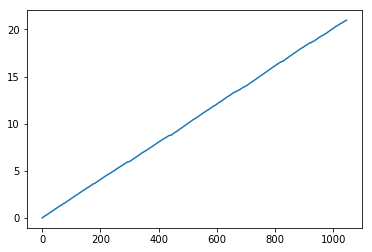

In [13]:
import numpy as np
plt.plot(np.array(d_list).cumsum())

In [70]:
np.array(d_list).cumsum()[-1]

20.968103009634387

In [15]:
import requests

In [21]:
#CONSTRUCT JSON
d_ar=[{}]*len(lat_list[:2])
for i in range(len(lat_list[:2])):
    d_ar[i]={"latitude":lat_list[i],"longitude":lon_list[i]}
location={"locations":d_ar}
json_data=json.dumps(location,skipkeys=int).encode('utf8')


# #SEND REQUEST 
url="https://api.open-elevation.com/api/v1/lookup"
# response = urllib.request.Request(url,json_data,headers={'Content-Type': 'application/json'})
# fp=urllib.request.urlopen(response)

# import requests
header = {
        'Content-Type': 'application/json; charset=UTF-8',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36'
    }
res = requests.post(url, json = location, headers = header)
# requests.post(url, json=json_data)

SSLError: HTTPSConnectionPool(host='api.open-elevation.com', port=443): Max retries exceeded with url: /api/v1/lookup (Caused by SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')")))

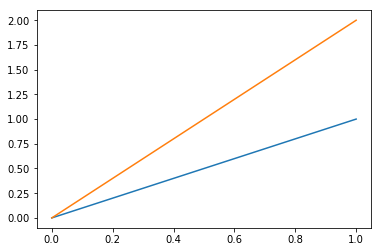

In [105]:
fig, ax = plt.subplots()

v1 = np.array([[0, 0], [1, 2]])


plt.plot(v1)


In [106]:
import numpy as np

In [123]:
v1 = np.array([[0, 0], [5, 5]])
v2 = np.array([[0, 0], [2, 2]])

v1_diff =  v1[1,:] - v1[0,:] 
v2_diff =  v2[1,:] - v2[0,:] 

np.math.atan2(np.linalg.det([v1_diff, v2_diff]), np.dot(v1_diff, v2_diff))

0.0

In [127]:
v1_diff

array([5, 5])